In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from sklearn.metrics import pairwise
from sklearn.metrics import accuracy_score
from statsmodels import robust
# %matplotlib inline

In [2]:
class FileUtilities(object):
    """ 
        Reads the CSI data 
    """
    def __init__(self, path):
        super(FileUtilities, self).__init__()
        self.path = path
        self.data_matrices = []
        self.amplitude = []
        self.labels = []
        print("FileUtilities initialized")
        
    def read_csv(self,file):
        return pd.read_csv(file)

    def get_data_matrix(self,df):
        """ Returns the timestamps, amplitude and phase as a single matrix """
        return(df.as_matrix())

    def get_data_matrices(self):
        files = os.listdir(self.path)
        for file in files:
            df = self.read_csv(self.path+file)
            # label = str(str(file).split('-')[1])
            label = str(str(file).split('_')[3])
            self.labels.append(label)
            print("Reading " + str(file) + "...")
            data = self.get_data_matrix(df)
            self.data_matrices.append(data)
        print("FileUtilities::get_data_matrices read %d files" %(len(self.data_matrices)))
        return self.data_matrices

    def get_amplitude_matrices(self):
        if not self.data_matrices:
            self.get_data_matrices()
        for data_matrix in self.data_matrices:
            self.amplitude.append(np.array(data_matrix[:,1:]))		# for new data
            # self.amplitude.append(np.array(data_matrix[:,1:91]))
        return self.amplitude
    
    def plot_reading_amp_summed(self,input_file):
        df = self.read_csv(self.path+input_file)
        data = self.get_data_matrix(df)
        s = data[:,1:31]
        res = np.sum(s,axis = 0)
        return res
    
    def plot_reading_amp_subcarrier(self,input_file,subcarrier_index):
        df = self.read_csv(self.path+input_file)
        data = self.get_data_matrix(df)
        s = data[:,subcarrier_index]
        return s

In [3]:
def extract_label(x):
    y = []
    for p in x:
        tmp = p.split('-')
        y.append(tmp[1]+'-'+tmp[2])
    return y

In [4]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [5]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
def second_filter(a,eps):
    n = a.shape[0]
    tmp = []
    for i in range(0,n):
        w_min = max(i-eps,0)
        w_max = min(i+eps,n-1)
        win = a[w_min:w_max+1]
        tmp.append(win)
    tmp = np.array(tmp)
    S = [np.count_nonzero(i) for i in tmp]
    return np.array(S)

In [7]:
def get_ranges(a):
    ranges = []
    i = 0
    while (i < a.shape[0]):
        if (i < a.shape[0] and a[i] == 0):
            i += 1
            continue
        else:
            begin = i
            while (i < a.shape[0] and a[i] == 1):
                i += 1
            ranges.append(np.array([begin,i-1]))
    return (np.array(ranges))

In [21]:
def get_wi_chase_features(act):
    m = np.mean(act,axis=0)
    sd = np.std(act,axis=0)
    p25 = np.percentile(act, 25, axis=0)
    p75 = np.percentile(act, 75, axis=0)
    mad = robust.mad(act,axis=0)
    mx = np.amax(act,axis=0)
    return np.array([m,sd,p25,p75,mad,mx])

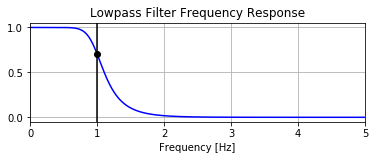

In [22]:
# Filter requirements.
order = 5
fs = 10        # sample rate, Hz
cutoff = 1   # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)
# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

FileUtilities initialized
(295, 30)
(295, 30)


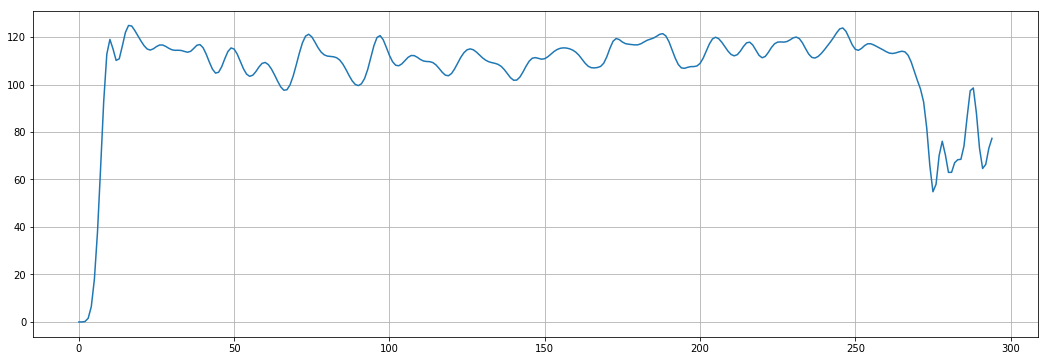

In [23]:
path = '/Users/Apple/Documents/git-aryans/data/loc_liv/'

# input_file = '1-empty-parsed.csv'
input_file = '2-typing-parsed.csv'
# input_file = '3-vaccume-parsed.csv'

utl = FileUtilities(path)
df = utl.read_csv(path+input_file)
data = utl.get_data_matrix(df)
antA = data[:,1:31]
print(antA.shape)
antA_filtered = np.zeros(antA.shape)
print(antA_filtered.shape)
for i in range(0,30):
    subcarrier_i = antA[:,i]
    subcarrier_i_filtered = butter_lowpass_filter(subcarrier_i, cutoff, fs, order)
    antA_filtered[:,i] = subcarrier_i_filtered
variance = np.var(antA_filtered,axis=1)
plt.figure(figsize=(18,6))
plt.grid()
plt.plot(variance)

FileUtilities initialized
(960, 30)
(960, 30)


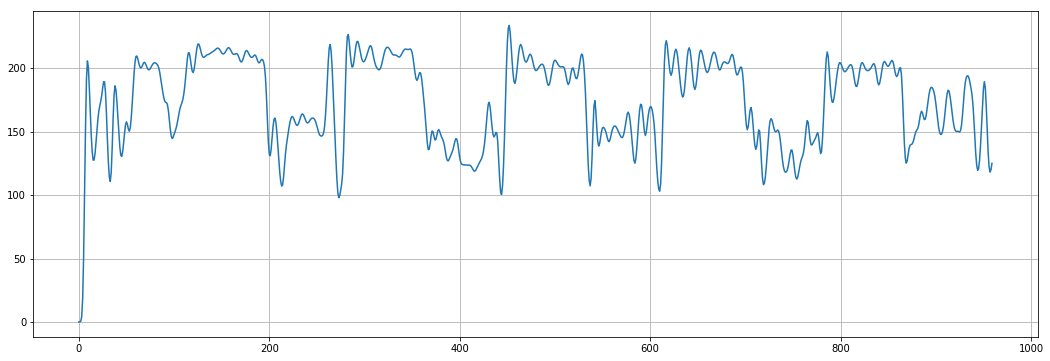

In [24]:
path = '/Users/Apple/Documents/git-aryans/data/walking_loc_liv/'

input_file = 'LivingToBed1-parsed.csv'
# input_file = 'LivingToBed2-parsed.csv'
# input_file = 'LivingToKitchen1-parsed.csv'
# input_file = 'LivingToKitchen2-parsed.csv'
# input_file = 'BedToBath1-parsed.csv'
# input_file = 'BedToBath2-parsed.csv'

utl = FileUtilities(path)
df = utl.read_csv(path+input_file)
data = utl.get_data_matrix(df)
antA = data[:,1:31]
print(antA.shape)
antA_filtered = np.zeros(antA.shape)
print(antA_filtered.shape)
for i in range(0,30):
    subcarrier_i = antA[:,i]
    subcarrier_i_filtered = butter_lowpass_filter(subcarrier_i, cutoff, fs, order)
    antA_filtered[:,i] = subcarrier_i_filtered
variance = np.var(antA_filtered,axis=1)
plt.figure(figsize=(18,6))
plt.grid()
plt.plot(variance)

In [25]:
# Normalizing variance 
mean = np.mean(variance)
std_dev = np.std(variance)
Y = (variance-mean)/std_dev
print(np.mean(Y))
print(np.var(Y))

-2.6645352591e-16
1.0


activity_indicator_threshold = 0.5


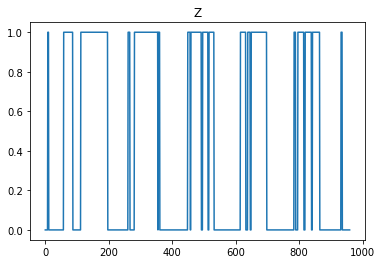

In [26]:
lmda = 0.5 # empirically determined
activity_indicator_threshold = lmda*np.std(Y)
print('activity_indicator_threshold = ' + str(activity_indicator_threshold))
Z = np.array([1 if x >= activity_indicator_threshold else 0 for x in Y])
plt.title('Z')
plt.plot(Z)

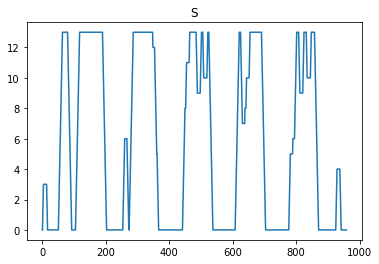

In [27]:
eps = 6 # empirically determined
S = second_filter(Z,eps)
plt.title('S')
plt.plot(S)

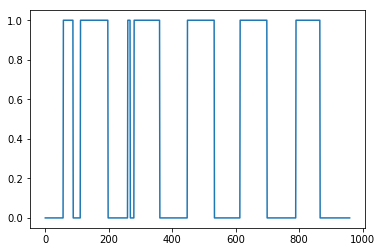

In [28]:
eta = 6  # empirically determined
activity = np.array([1 if x >= eta else 0 for x in S])
plt.plot(activity)

In [30]:
activity_ranges = get_ranges(activity)
for r in activity_ranges:
    act = antA_filtered[r[0]:r[1]+1]
    features = get_wi_chase_features(act)
    print(features.shape)

(6, 30)
(6, 30)
(6, 30)
(6, 30)
(6, 30)
(6, 30)
(6, 30)


In [ ]:
#todo
# train svm
# test